In [2]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pybedtools import BedTool

In [8]:
#Each record is a JSON structure associated with a case, and contains: 
#the case number; the primary site; and the chromosome, 
#the start position, and the stop position of the mutation; and some additional information. 

In [9]:
#The goal of this programming assignment is to write a classifier 
#that given some mutational information about a case predicts the primary site associated with the cancer.

In [10]:
#To do:
#separate training from testing
#make sure the cv is stratified
#consider a random forest instead( test)

#idea: per case_id, create an average across starting_position, the chromosome one hots, and all base one hots



In [5]:
#parse data with json package
with open('out.json') as exampleData2:
    parsedData2 = json.load(exampleData2)

#create dictionary organized by observation (i.e., "hit")
hitsDictionary = parsedData2["data"]["hits"]

#normalize the data into a dataframe
df = pd.io.json.json_normalize(hitsDictionary)

#modify column headings
df.columns = df.columns.map(lambda x: x.split(".")[-1])

In [6]:
#Data Cleaning:

#under the assumption that only one distinct gene is cited in the "consequence" column,
#extract gene name and place in new column
def gene_extract(row):
    entry = row['consequence']
    entry_transform = entry[0]["transcript"]["gene"]["symbol"]
    return entry_transform

df['gene_symbol'] = df.apply (lambda row: gene_extract(row), axis=1)

In [7]:
#attribute creation:
#count the number of times that the gene was cited in the "consequence" column,
#in order to use it later as a measure of strength of gene expression (?)

def gene_count(row):
    entry = row['consequence']
    entry_transform = len(entry)
    return entry_transform

df['gene_citations'] = df.apply (lambda row: gene_count(row), axis=1)

In [8]:
#delete the consequence column - no additional information here
del df['consequence']

In [9]:
#I can see that there is only one distinct mutation type and mutation subtype:
#therefore delete those two columns:

df_count5 = df["mutation_type"].nunique()
print("Mutation type:")
print(df_count5)

df_count5 = df["mutation_subtype"].nunique()
print("Mutation subtype:")
print(df_count5)


Mutation type:
1
Mutation subtype:
1


In [10]:
del df['mutation_type']
del df['mutation_subtype']

In [11]:
#SANITY CHECKS:

#check for repeats in "id" column
df_count = df['id'].nunique()
print("No repeat IDs?:", df_count == df.shape[0])
df_count2 = df['primary_site'].nunique()
print("Number of primary cancer sites:", df_count2)
df_count3 = df['case_id'].nunique()
print("Number of cases:", df_count3)
df_count4 = df['project_id'].nunique()
print("Number of projects:", df_count4)
df_count5 = df["chromosome"].nunique()
print("Number of chromosomes:", df_count5)
df_count6 = df["gene_symbol"].nunique()
print("Number of genes:", df_count6)
df_count7 = df["start_position"].nunique()
print("Number of start positions:", df_count7)



No repeat IDs?: True
Number of primary cancer sites: 26
Number of cases: 9097
Number of projects: 33
Number of chromosomes: 24
Number of genes: 18177
Number of start positions: 159995


In [12]:
#delete id because meaningless
del df['id']

#is end ever different from start? No:
np.sum(abs(df["end_position"] - df["start_position"]))

0

In [13]:
#therefore can delete one of them
del df['end_position']

In [14]:
#Tested that the chromosome in genomic_dna_change always equals the given chromosome.

#need to parse genomic_dna_change
#Here I remove bases

df['bases'] = df['genomic_dna_change'].str.slice(start=-3, stop=None, step=None)

#Here I identify the base changes
df['bases_first'] = df['bases'].str.slice(start=0, stop=1, step=None)
df['bases_second'] = df['bases'].str.slice(start=2, stop=3, step=None)

#note that the project_id is probably a label and relates to the primary_site label - cannot use as feature

del df['project_id']

In [15]:
this = pd.Series(df.primary_site)
unique, counts = np.unique(this, return_counts=True)
dict(zip(unique, counts))

{'Adrenal Gland': 809,
 'Bile Duct': 211,
 'Bladder': 9707,
 'Bone Marrow': 536,
 'Brain': 6999,
 'Breast': 7381,
 'Cervix': 5450,
 'Colorectal': 19118,
 'Esophagus': 1829,
 'Eye': 90,
 'Head and Neck': 6456,
 'Kidney': 2759,
 'Liver': 3030,
 'Lung': 26823,
 'Lymph Nodes': 413,
 'Ovary': 3518,
 'Pancreas': 1773,
 'Pleura': 207,
 'Prostate': 1465,
 'Skin': 18067,
 'Soft Tissue': 1098,
 'Stomach': 8773,
 'Testis': 163,
 'Thymus': 179,
 'Thyroid': 398,
 'Uterus': 55720}

In [16]:
55720/df.shape[0]

0.30452746868373304

In [17]:
#features: chromosome, start_position, gene_symbol, gene_citations, bases, genomic_dna_change
one_hot_chromosome = pd.get_dummies(df[['chromosome']], drop_first=True)
one_hot_bases = pd.get_dummies(df[['bases', 'bases_first', 'bases_second']], drop_first=True)  
data = pd.concat([df[[ 'start_position', 'gene_citations']], one_hot_chromosome, one_hot_bases], axis=1)
#, , 'gene_symbol',  ]] #, 'genomic_dna_change']]


target = np.ravel(np.array(df[['primary_site']]))
#clf_fit = clf.fit(data, target)
#cv = cross_val_score(clf, data, target, cv=10)


#chromosome is not great
#bases is helpful

In [18]:
#Split the data into training and test sets. 
#stratified sampling by iris class to ensure both the training and test sets contain a balanced 
#number of representatives of each of the three classes.
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=0)





clf = DecisionTreeClassifier(random_state=0)

#df['genecitations']=df['genecitations'].astype(float)




target = np.ravel(np.array(df[['primary_site']]))
#clf_fit = clf.fit(data, target)
#cv = cross_val_score(clf, data, target, cv=10)


rf = RandomForestClassifier() #(n_estimators=100, oob_score=True, random_state=123456)

#need stratification here also:
cv = cross_val_score(rf, X_train, y_train, cv=10)
#Consider using StratifiedKFold to preserve original data balance
cv

array([0.21934735, 0.21765549, 0.2217139 , 0.22351977, 0.22228294,
       0.2318098 , 0.22468225, 0.21958721, 0.22320208, 0.217314  ])

In [19]:
np.mean(cv) #21.76 is with decisiontree, 22.63 is with the above randomforest


0.2221114785274981

In [20]:
#aggregate the various mutations and associated genes for each case
#then determine whether the algorithm needs to be multiclass (one class per case) or multilabel (up to several)

#by case:

#initialize

data2 = pd.concat([df[[ 'case_id', 'primary_site']], data], axis=1)

cases = pd.DataFrame(0, index=[0], columns=data.columns)

target = []

for n in df['case_id'].unique():
    new_case = pd.DataFrame(data2[data2['case_id']== n ])
    
    new_primary_site = np.array(new_case.primary_site)[0]
    target.append(new_primary_site)

    del new_case['case_id']
    del new_case['primary_site']

    new_mat = pd.DataFrame(new_case.mean(axis=0)).T #average across the one-hots, or median across the one-hots
    cases = cases.append(new_mat)

cases = cases.iloc[1:] 

In [29]:
#Load the BEDfile and make sense of it
genes = BedTool('gencode.v22.annotation.bed.gz')
genes = genes.sort()

bedfile = df.loc[:,('chromosome','start_position', 'start_position')]
bedfile = BedTool(np.ndarray.tolist(np.array(bedfile)))
bedfile = bedfile.sort()



In [422]:
def hack1(x):
    if (x == 'X'):
        return 50
    else:
        if (x=='Y'):
            return 51
        else:
            return x

In [ ]:
#this will function as a lookup table
empty = np.zeros((214819, 4))
count=0

for nearest in BedTool(bedfile).closest(genes):
    #print(nearest[1]) #[4:5]
    empty[count,0] = hack1(nearest[0][3:])
    empty[count,1] = nearest[1]
    empty[count,2] = hack1(nearest[5][3:])
    empty[count,3] = nearest[6]
    count += 1

In [244]:
empty = empty.astype(int) #this mpas to 21,000 start points... Are they meaningful without chromosome number?
#the range of the startpoint looks like it's distinct per chromosome, so yes

In [190]:
keys1 = empty[:,0]
keys2 = empty[:,1]
values = empty[:,3]
mydict = dict(zip( zip(keys1.astype(int), keys2.astype(int)), values.astype(int)))



In [252]:
#test = np.ndarray.tolist(np.array(test))
#test = BedTool(test)
#print(test)

In [424]:
#for nearest in BedTool(bedfile).closest(genes):
 #   print(nearest)

    

In [442]:
#in df: chromosome, start_position
#make a new chromosome col to conform with the np array
#strip chr from new chrom col
df['new_chr'] = df['chromosome'].str.slice(3,)
df['new_chr'] = df['new_chr'] .apply (hack1)



#make a dictionary out of the lookup table
#want to add to 'df' dataframe: 'closest_gene' for each of 182,000 lines


empty_list = []

tuples = zip(np.array(df['new_chr']).astype(int), np.array(df['start_position']))
#x = np.array(df['new_chr']).astype(int)
#y = np.array(df['start_position'])

for x,y in tuples:
    empty_list.append( mydict[(x,y)] )

df['closest'] = empty_list


#then have to run it through the averaging thing againd






In [443]:
#aggregate the various mutations and associated genes for each case
#then determine whether the algorithm needs to be multiclass (one class per case) or multilabel (up to several)

#by case:

#initialize

data3 = pd.concat([df[[ 'case_id', 'primary_site', 'closest']], data], axis=1)

cases = pd.DataFrame(0, index=[0], columns=data3.columns[2:])

target = []

for n in df['case_id'].unique():
    new_case = pd.DataFrame(data3[data3['case_id']== n ])
    
    new_primary_site = np.array(new_case.primary_site)[0]
    target.append(new_primary_site)

    del new_case['case_id']
    del new_case['primary_site']

    new_mat = pd.DataFrame(new_case.mean(axis=0)).T #average across the one-hots, or median across the one-hots
    cases = cases.append(new_mat)

cases = cases.iloc[1:] 

In [445]:
cases

,closest,start_position,gene_citations,chromosome_chr10,chromosome_chr11,chromosome_chr12,chromosome_chr13,chromosome_chr14,chromosome_chr15,chromosome_chr16,...,bases_G>T,bases_T>A,bases_T>C,bases_T>G,bases_first_C,bases_first_G,bases_first_T,bases_second_C,bases_second_G,bases_second_T
0,8.635879e+07,8.643866e+07,5.310881,0.051813,0.041451,0.044905,0.025907,0.022453,0.024180,0.015544,...,0.367876,0.003454,0.005181,0.018998,0.493955,0.464594,0.027634,0.013817,0.020725,0.504318
0,9.606945e+07,9.610903e+07,6.419355,0.032258,0.129032,0.096774,0.032258,0.000000,0.064516,0.096774,...,0.161290,0.129032,0.000000,0.064516,0.419355,0.290323,0.193548,0.064516,0.161290,0.419355
0,8.175637e+07,8.181654e+07,5.776280,0.024259,0.043127,0.040431,0.016173,0.056604,0.051213,0.018868,...,0.353100,0.005391,0.005391,0.032345,0.485175,0.442049,0.043127,0.029650,0.037736,0.447439
0,8.687031e+07,8.694008e+07,5.756906,0.034530,0.059392,0.064917,0.019337,0.033149,0.037293,0.020718,...,0.215470,0.008287,0.033149,0.001381,0.426796,0.495856,0.042818,0.037293,0.017956,0.494475
0,8.028179e+07,8.034697e+07,5.499405,0.040428,0.053508,0.063020,0.027348,0.027348,0.043995,0.016647,...,0.306778,0.007134,0.008323,0.011891,0.500595,0.443520,0.027348,0.019025,0.026159,0.451843
0,5.297795e+07,5.298740e+07,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,6.640523e+07,6.650788e+07,6.750000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.250000,0.500000,0.250000,0.250000,0.000000,0.250000
0,7.756810e+07,7.761529e+07,6.000000,0.035714,0.089286,0.017857,0.017857,0.017857,0.071429,0.000000,...,0.142857,0.000000,0.107143,0.017857,0.375000,0.321429,0.125000,0.178571,0.142857,0.357143
0,6.066479e+07,6.068619e+07,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,...,0.125000,0.125000,0.000000,0.000000,0.500000,0.375000,0.125000,0.000000,0.125000,0.375000
0,5.742477e+07,5.746099e+07,4.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.666667


In [454]:
#Now for the aggregated data;

#Split the data into training and test sets. 
#stratified sampling by iris class to ensure both the training and test sets contain a balanced 
#number of representatives of each of the three classes.
X_train, X_test, y_train, y_test = train_test_split(cases, target, test_size=0.2, stratify=target, random_state=0)






#df['genecitations']=df['genecitations'].astype(float)


rf = RandomForestClassifier(n_estimators=100) #(n_estimators=100, oob_score=True, random_state=123456)

#need stratification here also:
cv = cross_val_score(rf, X_train, y_train, cv=10)
#Consider using StratifiedKFold to preserve original data balance
np.mean(cv)

#26.2 for aggregated w/o closest





0.25810147179044557

In [455]:
from sklearn.metrics import accuracy_score

rf.fit(X_train, y_train)

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy

0.27692307692307694

In [456]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=np.unique(target), index=np.unique(target))

In [464]:
162/np.sum(np.sum(cm))
#np.max(cm)

0.08901098901098901

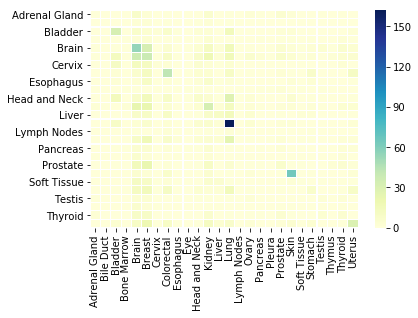

In [457]:
#plt.imshow(cm, cmap='cool')

sns.heatmap(cm, linewidth=0.1, cmap="YlGnBu" )

plt.show()
plt.figure(figsize=(20,15))


In [465]:
#which features are most important
features = pd.DataFrame(rf_fit.feature_importances_, data.columns)
features.columns = pd.Series('val')
features
features.sort_values(by='val', ascending=False)

NameError: name 'rf_fit' is not defined

In [189]:
clf = clf.fit(data, target)

pred = clf.predict(data)
ser = pd.Series(pred)
unique, counts = np.unique(ser, return_counts=True)
dict(zip(unique, counts))

{'Adrenal Gland': 904,
 'Bile Duct': 235,
 'Bladder': 10971,
 'Bone Marrow': 613,
 'Brain': 8106,
 'Breast': 8077,
 'Cervix': 5908,
 'Colorectal': 21236,
 'Esophagus': 1844,
 'Eye': 89,
 'Head and Neck': 6710,
 'Kidney': 2798,
 'Liver': 3061,
 'Lung': 26840,
 'Lymph Nodes': 389,
 'Ovary': 3374,
 'Pancreas': 1654,
 'Pleura': 184,
 'Prostate': 1400,
 'Skin': 17524,
 'Soft Tissue': 976,
 'Stomach': 8015,
 'Testis': 153,
 'Thymus': 175,
 'Thyroid': 350,
 'Uterus': 51386}

In [200]:
51386/df.shape[0]


0.28084078438230986

In [148]:
#initialize
counts = pd.DataFrame(index=df['primary_site'].unique(),columns=['count'])

for i in df['primary_site'].unique():
    counts.loc[i, 'count'] = np.sum(df['primary_site'] == i)

In [164]:
55720/np.sum(counts['count'])

0.30452746868373304

In [159]:
np.sum(counts) == df.shape[0]
counts

,count
Uterus,55720
Brain,6999
Colorectal,19118
Cervix,5450
Soft Tissue,1098
Liver,3030
Prostate,1465
Breast,7381
Skin,18067
Kidney,2759


In [70]:
np.sum(df['primary_site'] == 'Uterus')


0.30955555555555553

In [156]:
#a random classifier would have this accuracy:
1/26


0.038461538461538464